# Mise en évidence de l'effet de site

## Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import seaborn as sns # graphiques plus beaux

In [3]:
import pandas as pd

In [4]:
import os
from glob import glob

In [5]:
from obspy import read, read_inventory, UTCDateTime, Stream
from obspy.clients.fdsn import Client
from obspy.geodetics.base import gps2dist_azimuth
from obspy.signal.invsim import estimate_wood_anderson_amplitude
from obspy.core.event import read_events
from obspy.core.event.catalog import Catalog

In [6]:
import warnings
warnings.filterwarnings('ignore')
os.environ['PROJ_LIB'] = '~/.conda/envs/sismo/share/proj'

## Outils pour l'analyse de données

In [7]:
client = Client("RESIF") # Réseau français

In [8]:
stations = {'WALT', 'HOHE', 'CIEL', 'WLS', 'NEEW', 'SZBH', 'STR', 'ILLF', 'ZELS'}  # proche de l'Alsace
direction_plans = {"horizontale" : ("N", "E", "W", "S", "1", "2",), "verticale" : ("Z",)}
path = 'data/'
filename = 'data'

In [9]:
coordinates_plaine = {
    "minlatitude": 47.3,
    "maxlatitude": 49.1,
    "minlongitude": 6.5,
    "maxlongitude": 8.5,
}  # zone d'étude de la plaine

In [10]:
# Séisme induit de Strasbourg de référence
starttime = UTCDateTime(2021,6,26,3,0,0)
duration = 3*60 # secondes
location = (48.66, 7.82)

### Récupération des données/métadonnées des stations
Note : Les données semblent disponible qu'à partir de 2011.

In [11]:
def get_S(station, starttime=starttime, duration=duration):
    """télécharge les traces d'une station dans un intervalle de temps donné"""
    return client.get_waveforms("FR", station, "00", "HH*", starttime, starttime + duration)

In [12]:
def get_inventory(name, starttime=starttime, duration=duration):
    """télécharge les métadonnées d'une station dans un intervalle de temps donné"""
    return client.get_stations(network="FR", station=name, channel="HH*", starttime=starttime, level="response")

In [13]:
def download_S(stations=stations, path=path, filename=filename, extension='.miniseed', starttime=starttime, duration=duration, save=True):
    """télécharge les traces de différentes stations pour un même intervalle de temps et peut les enregistrer"""
    S = Stream()
    for station in stations:
        try:
            S += get_S(station, starttime=starttime, duration=duration)
        except Exception:
            pass
    if len(S) == 0:
        raise ValueError('Pas de données')
    if save:
        S.write(os.path.join(path, filename + extension), format="MSEED")
    return S

In [14]:
def download_inventory(stations=stations, path=path, filename=filename, extension='.xml', starttime=starttime, duration=duration, save=True):
    """télécharge les métadonnées de différentes stations pour un même intervalle de temps et peut les enregistrer"""
    inventory = get_inventory(','.join(stations), starttime=starttime, duration=duration)
    if save:
        inventory.write(os.path.join(path, filename + extension), format='STATIONXML')
    return inventory

In [15]:
def download(**kwargs):
    """télécharge à la fois les traces et les métadonnées pour différentes stations dans un intervalle de temps donné
    utilise les arguments de download_S ou download_inventory"""
    return (download_S(**kwargs), 
            download_inventory(**kwargs))

In [16]:
def load(path=path, filename=filename):
    """charge les données et les métadonnées"""
    return read(os.path.join(path, f'{filename}.miniseed')), read_inventory(os.path.join(path, f'{filename}.xml'))

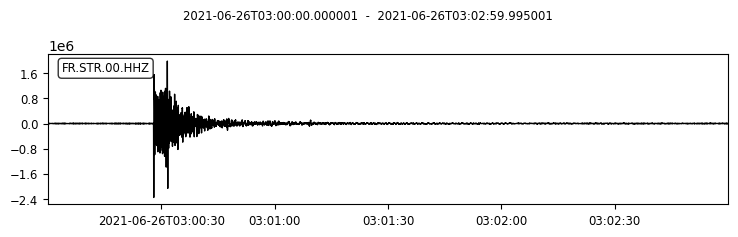

In [19]:
S, inventory = download(stations=stations, starttime=starttime, duration=duration, save=False)  # télécharge les données pour le séisme donné
T = S.select(station="STR", component="Z")[0]
_ = T.plot()

### Analyse du signal

#### Calculs préliminaires sur les traces

In [26]:
def filtrage(T):
    """filtre et nettoie la trace"""
    T.detrend("demean")
    T.taper(0.1)
    T.filter("bandpass", freqmin=1, freqmax=5)

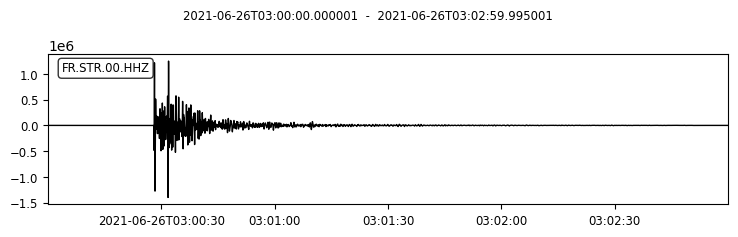

In [20]:
filtrage(S)
_ = T.plot() # T lié à S

In [79]:
inventory.write("stations.kml", format="KML")

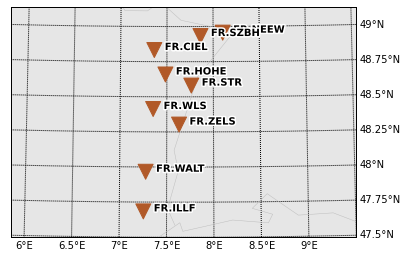

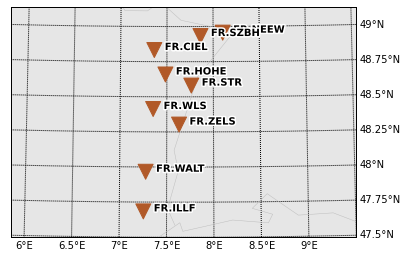

In [78]:
inventory.plot(projection='local')

#### Utilisation des métadonnées

In [17]:
def dist_epi(station, inventory, location):
    """calcule la distance à l'épicentre de la station en m"""
    stinv = inventory.select(station=station)[0][0]
    distance = gps2dist_azimuth(stinv.latitude, stinv.longitude, location[0], location[1])[0]
    return distance

In [46]:
dist_epi("STR", inventory, location)

9839.470651395313

In [19]:
def gain(T, inventory):
    """récupère le gain de la station"""
    chinv = inventory.select(channel=T.id.split('.')[-1])[0][0][0]
    gain = chinv.response.instrument_sensitivity.value
    return gain

In [24]:
gain(T, inventory)

2529796020.696

#### Amplitude maximale d'une trace

In [20]:
def amplitude_brut(T):
    """récupération de l'amplitude maximale brut d'une trace"""
    t = T.data
    amplitude = max(abs(t))
    return amplitude

In [26]:
amplitude_brut(T)

1401276.1555421299

#### Fréquences

In [21]:
def spectre(T):
    """dessine le spectre de la trace"""
    TFZ = np.fft.fft(T.data)/gain(T, inventory)
    f = np.fft.fftfreq(len(TFZ),T.stats.delta)

    plt.plot(f, np.abs(TFZ), label=T.id)
    plt.xlabel('frequence (Hz)')
    plt.ylabel('amplitude (m/s)')
    plt.xlim((0,10))
    plt.legend()

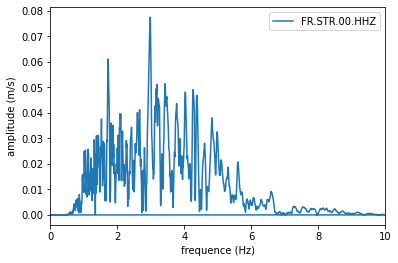

In [26]:
spectre(T)

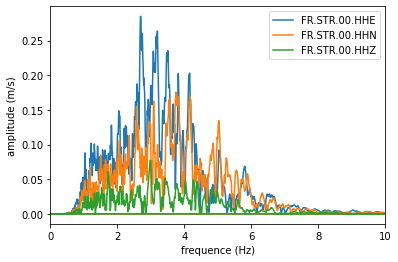

In [36]:
for T in S.select(station="STR"):
    spectre(T)
plt.show()

In [34]:
def freq_max(T):
    """fréquence correspondante au maximum d'amplitude"""
    TFZ = np.fft.fft(T.data)/gain(T, inventory)
    f = np.fft.fftfreq(len(TFZ),T.stats.delta)
    amplitude = np.argmax(TFZ)
    frequence = np.abs(f[amplitude])
    return frequence

In [28]:
freq_max(T)

2.9833333333333334

#### Magnitude locale
https://www.resif.fr/ressources/sismologie/dictionnaire-des-termes-de-sismologie/

In [37]:
def magnitude_locale(amplitude, distance):
    """
    calcul de la magnitude locale Ml
    amplitude : m/s
    distance : m
    """
    a = 0.018 # coefficients douteux -> simulation wood anderson à faire ?
    b = 2.17
    return np.log10(amplitude * 1000) + a * distance/1000 + b

### Généralisation pour plusieurs traces et stations

#### Récolte des données avec analyse

In [28]:
def get_amplitudes(S, inventory, location):
    """récolte les données sous forme de dictionnaire"""
    amplitudes = {}
    for T in S:
        amplitude = amplitude_brut(T)/gain(T, inventory)
        station = T.id.split('.')[1]
        direction = T.id[-1]
        
        try:
            amplitudes[station]
        except KeyError:
            amplitudes[station] = {"horizontale": [], "verticale": []}
            
        for plan in direction_plans:
            if direction in direction_plans[plan]:
                amplitudes[station][plan].append(amplitude)
                
        T.stats.distance = dist_epi(station, inventory=inventory, location=location)
    # np.average(amplitudes_values[plan])
    return amplitudes

In [35]:
def get_df(S, inventory, location):
    """récolte les données sous forme de tableau pd.DataFrame"""
    data = get_amplitudes(S, inventory, location)
    df = pd.DataFrame.from_dict(data=data, orient='index')
    df.index.name = 'station'
    df['nom'] = df.apply(lambda row: inventory.select(station=row.name)[0][0].site.name, axis=1)
    df['horizontale'] = df['horizontale'].apply(np.average)
    df['verticale'] = df['verticale'].apply(np.average)
    df['distance'] = df.apply(lambda row: dist_epi(row.name, inventory=inventory, location=location), axis=1)
    df['frequence'] = df.apply(lambda row: freq_max(S.select(station=row.name, component='Z')[0]), axis=1)
    df['Ml'] = df.apply(lambda row: magnitude_locale(max(row.horizontale, row.verticale), row.distance), axis=1)
    df['Mlv'] = df.apply(lambda row: magnitude_locale(row.verticale, row.distance), axis=1)
    df = df.sort_values(by='distance')
    return df

In [40]:
get_df(S, inventory, location)

,horizontale,verticale,nom,distance,frequence,Ml,Mlv
station,,,,,,,
STR,0.002694,0.000554,Strasbourg,9839.470651,2.983333,2.777480,2.090549
HOHE,0.000203,0.000180,Hohengœft,24730.920314,3.361111,1.922862,1.869979
CIEL,0.000246,0.000121,Vacanciel,38657.037798,1.388889,2.257550,1.949050
NEEW,0.000084,0.000066,Neewiller,38969.213465,2.449932,1.796989,1.689643
ZELS,0.000065,0.000068,Zelsheim,42143.981841,1.649954,1.763280,1.763280
WALT,0.000049,0.000097,Westhalten,87090.321688,1.366629,2.724182,2.724182
ILLF,0.000048,0.000028,Illfurth,116453.372036,1.749951,2.943513,2.718585


#### Exemple sur le séisme de référence

In [38]:
folder_name = "seismes"
local_path = os.path.join(path, folder_name)

In [39]:
# download(stations=stations, path=local_path, starttime=starttime, duration=duration, save=True) # télécharger les données dans le dossier séisme
S, inventory = load(path=local_path) # charge les données
Skeep = S.copy() # copie les données
filtrage(S) # filtre les données
df_seisme = get_df(S, inventory, location)

In [201]:
df_seisme

,horizontale,verticale,nom,distance,frequence,Ml,Mlv
station,,,,,,,
STR,0.002694,0.000554,Strasbourg,9839.470651,2.983333,2.777480,2.090549
HOHE,0.000203,0.000180,Hohengœft,24730.920314,3.361111,1.922862,1.869979
CIEL,0.000246,0.000121,Vacanciel,38657.037798,1.388889,2.257550,1.949050
NEEW,0.000084,0.000066,Neewiller,38969.213465,2.449932,1.796989,1.689643
ZELS,0.000065,0.000068,Zelsheim,42143.981841,1.649954,1.763280,1.763280
WALT,0.000049,0.000097,Westhalten,87090.321688,1.366629,2.724182,2.724182
ILLF,0.000048,0.000028,Illfurth,116453.372036,1.749951,2.943513,2.718585


Text(0.5, 1.0, 'Séisme induit de Strasbourg enregistré sur les stations alsaciennes')

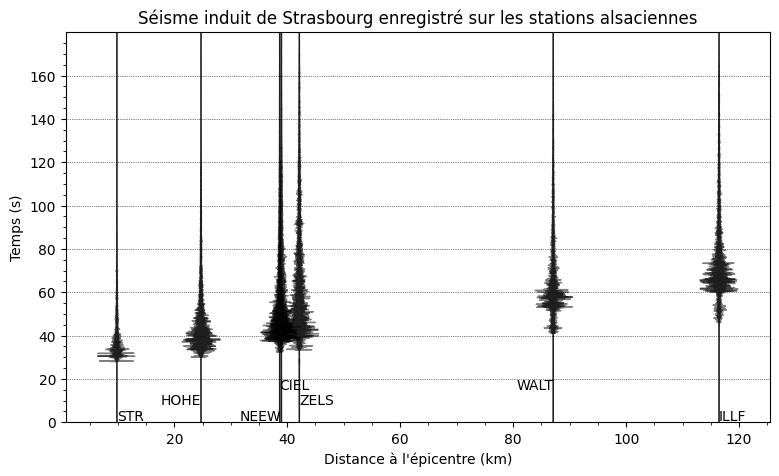

In [219]:
# S.plot(type='section') # simple plot
fig = plt.figure()
fig.set_size_inches(8, 5)
fig.set_dpi(100)
S.plot(type='section', fig=fig)
k = 0
for row in df_seisme.iterrows():
    T = S.select(station=row[0])[0]
    fig.axes[0].text(T.stats.distance/1e3, 1+(k%3)*7, s=T.stats.station, rotation=0, ha=("right" if k%2 else "left"))
    k += 1
plt.xlabel("Distance à l'épicentre (km)")
plt.ylabel("Temps (s)")
fig.axes[0].set_title('Séisme induit de Strasbourg enregistré sur les stations alsaciennes');

## Événement sismique

### Introduction de l'objet event permettant de décrire un événement

Pour chaque événement sismique nous avons besoin de la date du séisme pour charger les données et de la distance à l'épicentre pour calculer les magnitudes. L'objet event permet de donner ces informations. Plusieurs event peuvent être stocké dans un catalogue.

### Utilisation de l'API de France séismes pour récupérer les événements sismiques

In [25]:
url_query = "https://api.franceseisme.fr/fdsnws/event/1/query?{query}"  # webservice pour récupérer les évenements sous format quakeml
url_event = "https://renass.unistra.fr/fr/evenements/{event_id}/"  # suivre l'évenement sismique

In [26]:
def get_link(url=url_query, **kwargs):
    """renvoie le lien du catalogue correspondant en utilisant l'api de l'url donnée, les arguments sont ceux de l'api france connect"""
    arguments = {}
    for arg in kwargs:
        if kwargs[arg] != '':
            value = kwargs[arg]
            if type(value) is bool:
                value = str(value).lower()
            arguments[arg] = value

    query = '&'.join(f'{key}={arguments[key]}' for key in arguments if arguments[key] is not None)
    return url.format(query=query)

Exemple de l'utilisation de l'API

In [49]:
link = get_link(starttime=start_date, endtime=end_date, limit=5, latitude=47.68, longitude=7.25, maxradius=5.0)
print(link)
ev = read_events(link)
print(ev)
print(url_event.format(event_id=ev[0].resource_id.id.split('/')[-1]))

https://api.franceseisme.fr/fdsnws/event/1/query?orderby=magnitude&starttime=2015-01-01T00:00:00.000000Z&endtime=2022-01-01T00:00:00.000000Z&limit=5&latitude=47.68&longitude=7.25&maxradius=5.0
5 Event(s) in Catalog:
2019-11-11T10:52:45.840246Z | +44.526,   +4.642 | 5.201028883 MLv | manual
2015-11-06T04:03:03.926023Z | +44.491,   +6.739 | 4.147918342 MLv | manual
2019-05-28T08:48:06.474023Z | +46.349,   +6.768 | 4.124461027 MLv | manual
2016-11-10T02:48:13.479309Z | +44.277,   +6.168 | 4.047192 MLv | manual
2021-06-26T03:00:25.679648Z | +48.663,   +7.821 | 3.936604719 MLv | manual
https://renass.unistra.fr/fr/evenements/fr2019clftsg/


## Utilisation de ces outils pour la mise en évidence de l'effet de site

In [27]:
def calcul_rapport(folder, stations_comp=('ILLF', 'WLS', 'WALT'), column='verticale'):
    """Compare plusieurs stations par rapport à différent facteurs sur différents séismes"""
    S, inventory = download_event(folder)
    file = os.path.join(folder, f'output.csv')
    df_seisme = pd.read_csv(file, sep=';', index_col='station')
    n = len(stations_comp)
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            try:
                valeur = df_seisme[column][stations_comp[i]]/df_seisme[column][stations_comp[j]]
            except KeyError:
                valeur = 0
            A[i][j] = valeur
    df_rapports = pd.DataFrame(A)
    for name in ('index', 'columns'):
        df_rapports = df_rapports.rename(lambda i: stations_comp[i], axis=name)
    df_rapports.to_csv(os.path.join(folder, 'rapports.csv'), sep=';')
    return df_rapports

In [32]:
calcul_rapport("data/seismes_auto_plaine/fr2019axntmp")

Fichiers chargés dans data/seismes_auto_plaine/fr2019axntmp


,ILLF,WLS,WALT
ILLF,1.000000,13.836107,0.650362
WLS,0.072275,1.000000,0.047005
WALT,1.537606,21.274481,1.000000


### Automatisation de la recherche de séismes puis le traitement des données

In [81]:
folder_name = "seismes_auto_rapports"
local_path = os.path.join(path, folder_name)
local_stations = ('ILLF', 'WALT', 'ZELS', 'WLS', 'HOHE', 'CIEL')

In [82]:
start_date = UTCDateTime(2015, 1, 1)
end_date = UTCDateTime(2022, 1, 1)
duration = 3*60  # court car proche
latitude_illf = 47.68
longitude_illf = 7.25

In [83]:
link = get_link(
    starttime=start_date, endtime=end_date, 
    latitude=latitude_illf, longitude=longitude_illf, maxradius=1.0, 
    minmagnitude=2.3, orderby="magnitude")
print(f'Téléchargement de {link}')
events = read_events(link)
print(f'Téléchargé un total de {len(events)} événements')
events.write(os.path.join(local_path, 'raw-events.xml'), format="QUAKEML")

NameError: name 'get_link' is not defined

In [84]:
events = read_events(os.path.join(local_path, 'raw-events.xml'))

In [85]:
events.write("events.kml", format="KML")

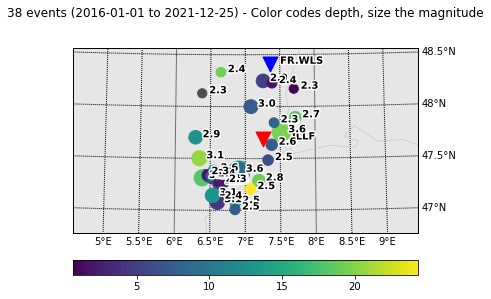

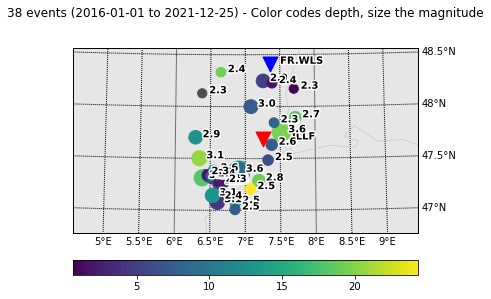

In [96]:
fig = events.plot(projection='local', show=False)
fig = inventory.select(station="ILLF").plot(color='red', fig=fig, show=False)
fig = inventory.select(station="WLS").plot(color='blue', fig=fig, show=False)
fig

In [189]:
new_events = read_events(os.path.join(local_path, 'new-events.xml'))

In [190]:
def download_event(folder, starttime=starttime):
    """Charge ou télécharge (s'il ne les trouve pas) les traces et les inventaire correspondant à un événement commençant à la date donnée dans le dossier donné."""
    if not os.path.isdir(folder):
        os.makedirs(folder)
        print(f'Dossier {folder} créé')
    try:
        S, inventory = load(path=folder)
        print(f'Fichiers chargés dans {folder}')   
    except FileNotFoundError:
        print(f'Téléchargement des fichiers dans {folder}')
        S, inventory = download(stations=local_stations, path=folder, starttime=starttime, duration=duration)
    return S, inventory

In [191]:
def process_event(S, inventory, event, folder):
    """Utilise les données de l'événement pour les analyse et stock les fichiers traités dans le dossier donné"""
    filtrage(S)
    df_seisme = get_df(S, inventory, location=(event.origins[0].latitude, event.origins[0].longitude))
    df_seisme.to_csv(os.path.join(folder, 'output.csv'), sep=';')
    return df_seisme

In [192]:
def graph_event(S, inventory, df_seisme, folder, title):
    """Dessine les traces d'un séisme donné"""
    fig = plt.figure()
    fig.set_size_inches(8, 5)
    fig.set_dpi(100)
    fig.patch.set_facecolor('white')
    S.plot(type='section', fig=fig, outfile=os.path.join(folder, 'raw_output.png'))
    k = 0
    for row_seisme in df_seisme.iterrows():
        T = S.select(station=row_seisme[0])[0]
        fig.axes[0].text(T.stats.distance/1e3, 1+(k%3)*10, s=T.stats.station)
        k += 1
    fig.axes[0].set_title(title)
    plt.xlabel("Distance à l'épicentre (km)")
    plt.ylabel("Temps (s)")
    fig.savefig(os.path.join(folder, 'output.png'), dpi=300)
    print(f'Processed graph')

In [193]:
new_events = Catalog()
for k, event in enumerate(events):
    starttime = event.origins[0].time
    event_id = event.resource_id.id.split('/')[-1]
    title = f'{event.event_descriptions[0].text} ({starttime.strftime("%d/%m/%Y")})'
    folder = os.path.join(local_path, event_id)
    
    print(k, title, url_event.format(event_id=event_id))
    
    try:
        S, inventory = download_event(starttime=starttime, folder=folder)
    except ValueError:
        continue
    if len(S.select(channel='**Z')) < len(local_stations):
        continue
    print('Fichiers comprennant suffisamment de données, analyse...')
    df_seisme = process_event(S, inventory, event, folder)
    df_rapport = calcul_rapport(folder, stations_comp=local_stations)
    # graph_event(S, inventory, df_seisme, folder, title)
    new_events += event

0 Earthquake of magnitude 4.1, near of Belfort (24/12/2021) https://renass.unistra.fr/fr/evenements/fr2021ibrhaj/
Fichiers chargés dans data/seismes_auto_rapports/fr2021ibrhaj
Fichiers comprennant suffisamment de données, analyse...
Fichiers chargés dans data/seismes_auto_rapports/fr2021ibrhaj
1 Earthquake of magnitude 3.6, near of Belfort (25/12/2021) https://renass.unistra.fr/fr/evenements/fr2021ibuhzp/
Fichiers chargés dans data/seismes_auto_rapports/fr2021ibuhzp
Fichiers comprennant suffisamment de données, analyse...
Fichiers chargés dans data/seismes_auto_rapports/fr2021ibuhzp
2 Earthquake of magnitude 3.6, near of Mulhouse (04/05/2018) https://renass.unistra.fr/fr/evenements/fr2018ykeudl/
Fichiers chargés dans data/seismes_auto_rapports/fr2018ykeudl
Fichiers comprennant suffisamment de données, analyse...
Fichiers chargés dans data/seismes_auto_rapports/fr2018ykeudl
3 Earthquake of magnitude 3.3, near of Besançon (13/01/2016) https://renass.unistra.fr/fr/evenements/fr2016sgvsis/

Fichiers chargés dans data/seismes_auto_rapports/fr2019aqwqdo
30 Earthquake of magnitude 2.4, near of Épinal (16/01/2018) https://renass.unistra.fr/fr/evenements/fr2018xptenx/
Fichiers chargés dans data/seismes_auto_rapports/fr2018xptenx
Fichiers comprennant suffisamment de données, analyse...
Fichiers chargés dans data/seismes_auto_rapports/fr2018xptenx
31 Quarry blast of magnitude 2.4, near of Besançon (09/05/2019) https://renass.unistra.fr/fr/evenements/fr2019bcbkxx/
Fichiers chargés dans data/seismes_auto_rapports/fr2019bcbkxx
Fichiers comprennant suffisamment de données, analyse...
Fichiers chargés dans data/seismes_auto_rapports/fr2019bcbkxx
32 Earthquake of magnitude 2.4, near of Mulhouse (12/10/2018) https://renass.unistra.fr/fr/evenements/fr2018zoqbsd/
Fichiers chargés dans data/seismes_auto_rapports/fr2018zoqbsd
Fichiers comprennant suffisamment de données, analyse...
Fichiers chargés dans data/seismes_auto_rapports/fr2018zoqbsd
33 Quarry blast of magnitude 2.3, near of Épina

In [194]:
rapports = []
for event in new_events:
    event_id = event.resource_id.id.split('/')[-1]
    folder = os.path.join(local_path, event_id)
    df_rapport = pd.read_csv(os.path.join(folder, 'rapports.csv'), sep=';', index_col=[0])
    if any(not df_rapport[station][station] == 1.0 for station in df_rapport):
        continue
    rapports.append(df_rapport)
df_rapports = sum(rapports)/len(rapports)

In [333]:
import matplotlib.colors as mcolors
colors1 = plt.cm.Reds(np.linspace(0., 1, 16*16))
colors2 = plt.cm.Blues(np.linspace(0, 1, 14))
colors = np.vstack((colors1[::-1], np.array([0.3, 0.3, 0.3, 1.]), colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors).reversed()

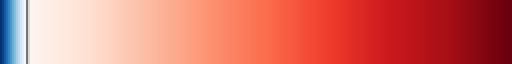

In [334]:
mymap

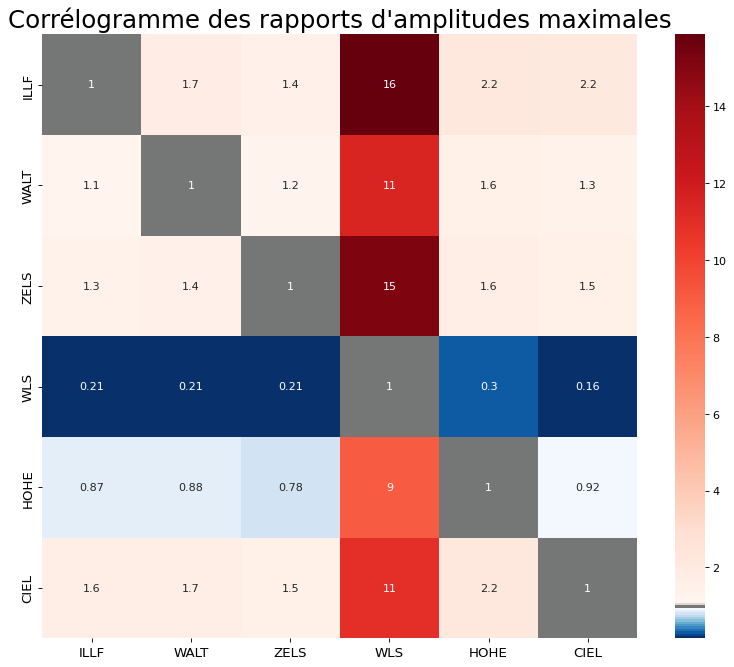

In [337]:
df = df_rapports
# Plot
plt.figure(figsize=(12,10), dpi= 80)

# sns.heatmap(df, xticklabels=df.index, yticklabels=df.columns, cmap='coolwarm', center=1, annot=True)
sns.heatmap(df, xticklabels=df.index, yticklabels=df.columns, cmap=mymap, annot=True)

# Decorations
plt.title("Corrélogramme des rapports d'amplitudes maximales", fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('Correlogramme')

In [173]:
df_rapports

,WALT,HOHE,CIEL,WLS,STR,ILLF,ZELS
WALT,1.000000,1.557206,1.325919,11.461977,1.367693,1.143584,1.203725
HOHE,0.878059,1.000000,0.920279,9.031366,0.824579,0.870761,0.776924
CIEL,1.664835,2.234279,1.000000,10.929600,0.995345,1.646912,1.524806
WLS,0.205820,0.295533,0.155387,1.000000,0.175289,0.213693,0.209249
STR,3.922874,4.432271,2.957651,43.961720,1.000000,3.725421,2.521932
ILLF,1.696606,2.183745,2.162258,15.878347,1.760000,1.000000,1.440046
ZELS,1.398762,1.641372,1.509762,15.189353,1.121037,1.323927,1.000000


In [180]:
df_rapports["WLS"]["STR"]

43.961720033542612

# Temporaire

In [263]:
new_events = Catalog()

In [145]:
new_events.write(os.path.join(local_path, 'new-events.xml'), format="QUAKEML")

In [118]:
event = events[54]
starttime = event.origins[0].time
event_id = event.resource_id.id.split('/')[-1]
title = f'{event.event_descriptions[0].text} ({starttime.strftime("%d/%m/%Y")})'
folder = os.path.join(local_path, event_id)

In [ ]:
start_date = UTCDateTime(2015, 1, 1)
end_date = UTCDateTime(2022, 1, 1)
duration = 3*60  # court car proche
latitude_illf = 47.68
longitude_illf = 7.25

# Commandes utiles

In [ ]:
os.makedirs(local_path)

In [239]:
df = pd.read_clipboard()

In [241]:
df.to_csv(f'{local_path}.csv', sep=';')

## Installer geopsy
`cd /geopsy
git clone git://geopsy.org/geopsypack
cd geopsypack
git checkout 3.4
git submodule update --init
./configure -builddir /geopsy -prefix /usr/local/Geopsy.org -march native
make -j 8 -C /geopsy
make install -C /geopsy`